In [64]:
import pandas as pd
import tqdm
import datetime
df = pd.read_csv("./daily/stock_2024-12-26.csv")
cdf = pd.read_csv("stock_today.csv")
fdf = pd.read_csv("./daily/stock_fund_2024-12-26.csv")
cfdf = pd.read_csv("stock_fund_today.csv")
fdf = pd.concat([fdf,cfdf])
df = pd.concat([df,cdf])
df = df.merge(fdf)


def make_record(g):
    if g.shape[0]>=10:
        name = g.iloc[0]["name"]
        last_1day, last_3_days, last_7days = g.iloc[0], g.iloc[1:3], g.iloc[5:]
        last_7day_volume = last_7days.volume.mean()
        last_3day_volume = last_3_days.volume.mean()/last_7day_volume
        last_1day_volume = last_1day.volume/last_7day_volume
        last_3day_vchange = g.iloc[2].volume/g.iloc[1].volume
        last_2day_vchange = g.iloc[1].volume/g.iloc[2].volume
        last_1day_vchange = last_1day.volume/g.iloc[1].volume
        last_1day_gap = (g.close.max()-g.iloc[0].close)/last_7days.close.mean()
        last_7day_change = g.iloc[3].close/g.iloc[-1].close
        last_3day_change = g.iloc[2].close/g.iloc[3].close
        last_2day_change = g.iloc[1].close/g.iloc[2].close
        last_1day_change = g.iloc[0].close/g.iloc[1].close
        last_1day_cc = (last_1day.close/last_1day.open-1)*100
        last_1day_cm = ((last_1day.high-last_1day.close)/g.iloc[1].close)*100
        last_1day_cl = ((last_1day.close-last_1day.low)/g.iloc[1].close)*100
        last_1day_amp = ((last_1day.high-last_1day.low)/g.iloc[1].close)*100
        # print(g.iloc[0].volume,last_7day_volume,g.iloc[0])
        last_7day_change = (last_7day_change-1)*100
        last_3day_change = (last_3day_change-1)*100
        last_1day_change = (last_1day_change-1)*100
        return {"name":name,"last_3day_volume":last_3day_volume,"last_1day_volume":last_1day_volume,
                "last_7day_change":last_7day_change,"last_1day_gap":last_1day_gap,"last_1day_vchange":last_1day_vchange,"last_2day_vchange":last_2day_vchange,"last_3day_vchange":last_3day_vchange,"last_3day_change":last_3day_change,"last_2day_change":last_2day_change,"last_1day_change":last_1day_change,"last_1day_cm":last_1day_cm,
                "last_1day_cc":last_1day_cc,"last_1day_cl":last_1day_cl,"last_1day_amp":last_1day_amp,
                "main_amount":g.iloc[0]["main_amount"], "main_percent":g.iloc[0]["main_percent"]}


def make_data(df,cdates,flag=True):
    records = []
    for k,g in tqdm.tqdm(df.sort_values(by="date",ascending=False).groupby("code"),
                         desc=f"processing date[{cdates[0]}--{cdates[-1]}]"):
        for cdate in cdates:
            pg = g[g.date<cdate][:10]
            record = make_record(pg)
            if record:
                record["date"]=cdate
                record["code"]=k
                if flag:
                    cg = g[g.date==cdate]
                    if cg.shape[0]>0 and pg.shape[0]>0:
                        change = cg.iloc[0].close/pg.iloc[0].close
                        change = (change-1)*100
                        if change>10:
                            change = 10
                        elif change<-10:
                            change = -10
                        record["change"]=change/10
                        records.append(record)
                else:
                    records.append(record)
        # break
                
    return pd.DataFrame(records)

def get_dates(cdt, days=3):
    ctm = datetime.datetime.strptime(cdt,"%Y-%m-%d")
    dts = []
    for i in range(1, days+3):
        delta = datetime.timedelta(days=-i)
        ttm = ctm+delta
        if ttm.weekday() <5:
            dts.append(ttm.strftime("%Y-%m-%d"))
    return dts[:days]

cdt,lst = "2024-12-27", []
padf = tdf = make_data(df,get_dates(cdt,days=3),True)
cadf = make_data(df,[cdt],True)
cadf.head()

processing date[2024-12-27--2024-12-27]: 100%|██████████| 4415/4415 [00:22<00:00, 199.63it/s]


,name,last_3day_volume,last_1day_volume,last_7day_change,last_1day_gap,last_1day_vchange,last_2day_vchange,last_3day_vchange,last_3day_change,last_2day_change,last_1day_change,last_1day_cm,last_1day_cc,last_1day_cl,last_1day_amp,main_amount,main_percent,date,code,change
0,浦发银行,1.743145,1.356390,2.795031,0.001044,0.840700,0.861454,1.160828,2.014099,1.021718,-0.096618,0.483092,-0.096618,1.739130,2.222222,-37422257.0,-5.96,2024-12-27,sh600000,0.019342
1,白云机场,0.761254,0.789881,-2.222222,0.020342,1.054926,0.967694,1.033385,0.826446,1.001025,-0.716479,1.023541,-0.919305,0.102354,1.125896,10092800.0,8.80,2024-12-27,sh600004,0.164948
2,东风股份,0.401441,1.253855,-11.800487,0.048689,3.190306,0.958907,1.042854,0.551724,0.976680,9.971910,0.000000,10.281690,10.393258,10.393258,207319492.0,23.78,2024-12-27,sh600006,-0.127714
3,中国国贸,0.316514,0.284674,2.134016,0.014067,0.869952,1.070083,0.934507,2.047639,1.007781,-1.381552,2.194230,-0.938776,0.325071,2.519301,-3133435.0,-5.12,2024-12-27,sh600007,0.065925
4,首创环保,0.713527,0.588005,-2.388060,0.026770,1.004202,0.695827,1.437138,2.140673,1.002994,-1.194030,1.492537,-1.194030,0.597015,2.089552,4677234.0,2.32,2024-12-27,sh600008,0.120846


In [65]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score,roc_auc_score,mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor, RandomForestClassifier
from lightgbm.sklearn import LGBMRegressor
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr
pdf =padf.dropna().copy()
pdf = pdf[pdf["last_1day_amp"]>0.1]
y = pdf.pop("change")
pdf.drop(columns=["code","name","date"],inplace=True)
X = pdf
# Create a pipeline with preprocessor and classifier
# model = Pipeline(steps=[ ('regressor', GradientBoostingRegressor())])
model = Pipeline(steps=[ ('regressor', LGBMRegressor())])
param_distributions = {'regressor__n_estimators': [100,],
                       'regressor__subsample_for_bin':[5000,],
                        'regressor__learning_rate': [0.01, 0.05,],
                        'regressor__num_leaves': [20, 30],
                        'regressor__subsample': [0.7,0.8],
                        'regressor__min_child_samples': [5, 8]}
# Create RandomizedSearchCV object
random_search = RandomizedSearchCV(estimator=model, 
    param_distributions=param_distributions, 
    n_iter=8,  # Number of parameter settings that are sampled
    cv=5,  # 5-fold cross-validation
    verbose=0,
    scoring = 'r2',
    random_state=42,
    n_jobs=-1  )
# Fit the RandomizedSearchCV model
random_search.fit(X, y)
best_gb = random_search.best_estimator_


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001905 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 13171, number of used features: 16
[LightGBM] [Info] Start training from score 0.005518


MSE is: 8.98022685263013
The Pearson Correlation Coefficient is:0.01


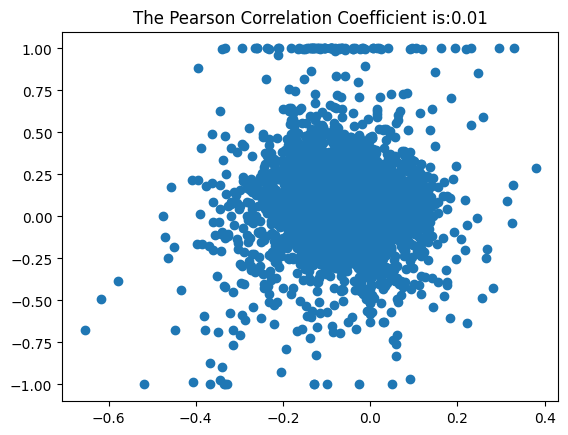

In [67]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr


pdf =cadf.dropna().copy()
pdf = pdf[pdf["last_1day_amp"]>0.1]
y = pdf.pop("change")
pdf.drop(columns=["code","name","date"],inplace=True)
X = pdf
test_prediction_gb = best_gb.predict(X)

print(f"MSE is: {mean_squared_error(y*10, test_prediction_gb*10)}")
res = pearsonr(test_prediction_gb, y)
print(f"The Pearson Correlation Coefficient is:{res[0]:.2f}")

res = pearsonr(test_prediction_gb, y)
plt.scatter(test_prediction_gb, y)
plt.title(f"The Pearson Correlation Coefficient is:{res[0]:.2f}")
plt.show()

In [68]:
pdf = cadf.copy()
pdf = pdf[pdf["last_1day_amp"]>0.1]
ctrain = pdf.drop(columns=["code","name","date","change"])
pdf["pred"] = random_search.predict(ctrain)*10
pdf["change"] = pdf["change"]*10
pdf = pdf[["date","code","name","pred","change","last_1day_change","last_1day_vchange","last_1day_volume"]]
# pdf[(pdf.last_1day_change>-8)&(pdf.last_1day_change<8)].sort_values(by="pred",ascending=False)[:10]
# pdf[(pdf.last_1day_change>3)&(pdf.last_1day_change<8)].sort_values(by="pred",ascending=False)[:20]
pdf.sort_values(by="pred",ascending=False)[:50]

,date,code,name,pred,change,last_1day_change,last_1day_vchange,last_1day_volume
642,2024-12-27,sh600857,宁波中百,3.793066,2.896725,9.972299,0.494535,0.433026
508,2024-12-27,sh600693,东百集团,3.301134,10.000000,10.062893,1.540581,1.254429
437,2024-12-27,sh600601,方正科技,3.271388,1.875000,10.091743,1.624473,1.717567
2169,2024-12-27,sz002028,思源电气,3.253212,-0.382253,0.356213,1.235575,0.396214
2809,2024-12-27,sz002752,昇兴股份,3.142200,0.921659,9.966216,1.084342,0.282321
285,2024-12-27,sh600391,航发科技,2.961763,10.000000,10.000000,6.455821,4.262113
2058,2024-12-27,sz001209,洪兴股份,2.816029,-4.242424,10.000000,0.837907,0.476021
1993,2024-12-27,sz000912,泸天化,2.688405,-1.948052,7.192575,4.122832,2.461326
3055,2024-12-27,sz003027,同兴科技,2.665490,-2.498438,10.034364,0.745513,0.585879
3171,2024-12-27,sz300114,中航电测,2.583555,5.911330,0.164474,0.680342,1.052805


In [14]:
pdf[pdf.name=="齐心集团"]

,name,last_3day_volume,last_1day_volume,last_7day_change,last_1day_gap,last_1day_vchange,last_2day_vchange,last_3day_vchange,last_3day_change,last_2day_change,last_1day_change,last_1day_cm,last_1day_cc,last_1day_cl,last_1day_amp,main_amount,main_percent,date,code,pred
2417,齐心集团,0.362028,0.531779,-19.525351,0.222276,1.883956,0.638919,1.565145,-2.412869,0.998626,2.200825,1.100413,2.766252,3.026135,4.126547,201765.0,0.14,2024-12-30,sz002301,1.235155
